Enfoque del dataset de noticias falsas basado en RNN con BiLSTM

In [8]:
### IMPORTS ###
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

import matplotlib.pyplot as plt

from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

import tensorflow as tf 
tf.random.set_seed(55) # para asegurar experimentos son reproducibles
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.metrics import accuracy_score, classification_report 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Cargar Dataset

In [9]:
### DRIVE DATA ###
from google.colab import drive

drive.mount('/content/drive', force_remount=True)
PATH = "/content/drive/My Drive/TFM/Data/FakeNews_Multi/"

Mounted at /content/drive


In [10]:
### CONJUNTOS DE ENTRENAMIENTO, VALIDACIÓN Y TEST ###
df = pd.read_csv(PATH + "train.csv",  sep=',', on_bad_lines='skip')
df = df[['Text', 'Labels']]
df=df.rename(columns={"Text": "Text", "Labels": "Label"})

X = df['Text']
y = df['Label']

X_train, X_aux, y_train, y_aux = train_test_split(X, y, test_size=0.30, random_state=55, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_aux, y_aux, test_size=2/3, random_state=55, stratify=y_aux)

X_train = list(X_train)
X_val = list(X_val)
X_test = list(X_test)

print('Tamaño conjunto de Entrenamiento:', len(X_train))
print('Tamaño conjunto de Validación:', len(X_val))
print('Tamaño conjunto de Evaluación:', len(X_test))

Tamaño conjunto de Entrenamiento: 7168
Tamaño conjunto de Validación: 1024
Tamaño conjunto de Evaluación: 2048


# Label Encoding

In [11]:
### LABEL ENCODING ###
y_train = y_train.tolist()
y_val = y_val.tolist()
y_test = y_test.tolist()

LABELS = sorted(set(y_train))
NUM_LABELS = len(LABELS)

idx2label={}
label2idx={}
for index, label in enumerate(LABELS):
    label2idx.update([(label, index)])
    idx2label.update([(index, label)])

print('Labels:', label2idx)
le = LabelEncoder()

y_train = le.fit_transform(y_train)
y_train_cat = to_categorical(y_train)
y_val = le.fit_transform(y_val)
y_val_cat = to_categorical(y_val)
y_test = le.fit_transform(y_test)
y_test_cat = to_categorical(y_test)

Labels: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}


# Tokenización

In [12]:
tokenizer = Tokenizer(oov_token = True)
tokenizer.fit_on_texts(X_train)
tokenizer.word_index['<PAD>'] = 0

NUM_WORDS=len(tokenizer.word_index)
print("Tamaño del vocabulario ={}".format(NUM_WORDS))

MAX_LEN= 100 # longitud de la secuencia
encoded_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen = MAX_LEN, padding='post')
encoded_val = pad_sequences(tokenizer.texts_to_sequences(X_val), maxlen = MAX_LEN, padding='post')
encoded_test = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen = MAX_LEN, padding='post')

Tamaño del vocabulario =10492


# **BiLSTM**

In [13]:
EMBEDDING_SIZE=200
DROPOUT=0.4

model = Sequential()
# capa donde se crea la matriz de word embeddings
# Cada token está asociado con un entero (gracias a la tokenización)
# Cada entero está asociado a un vector de la matriz
# Las secuencias se representan con estos vectores
model.add(Embedding(NUM_WORDS, EMBEDDING_SIZE, input_length=MAX_LEN))

model.add(Bidirectional(LSTM(100, return_sequences=True, recurrent_dropout=0.2)))
# Añadimos una capaz droput después de la capa bilstm 
model.add(Dropout(DROPOUT))

model.add(Bidirectional(LSTM(50, recurrent_dropout=0.2)))
model.add(Dropout(DROPOUT))

model.add(Dense(50, activation='relu'))
model.add(Dense(NUM_LABELS, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 200)          2098400   
                                                                 
 bidirectional (Bidirectiona  (None, 100, 200)         240800    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 100, 200)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 100)              100400    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 50)                5

# Training

In [14]:
epochs = 10 # número de veces que pasamos sobre el conjunto de aprendizaje
batch_size = 16 

# training
history=model.fit(encoded_train, y_train_cat, batch_size=batch_size, epochs=epochs, validation_data=(encoded_val, y_val_cat), callbacks=[earlyStopping])


Epoch 1/10
448/448 [==============================] - 344s 747ms/step - loss: 1.7504 - accuracy: 0.2179 - val_loss: 1.7220 - val_accuracy: 0.2324
Epoch 2/10
448/448 [==============================] - 319s 712ms/step - loss: 1.6267 - accuracy: 0.3039 - val_loss: 1.7990 - val_accuracy: 0.2461
Epoch 3/10
448/448 [==============================] - 315s 703ms/step - loss: 1.3333 - accuracy: 0.4704 - val_loss: 2.0151 - val_accuracy: 0.2158
Epoch 4/10
448/448 [==============================] - 315s 702ms/step - loss: 0.9691 - accuracy: 0.6454 - val_loss: 2.3180 - val_accuracy: 0.2168


# Curvas de Aprendizaje

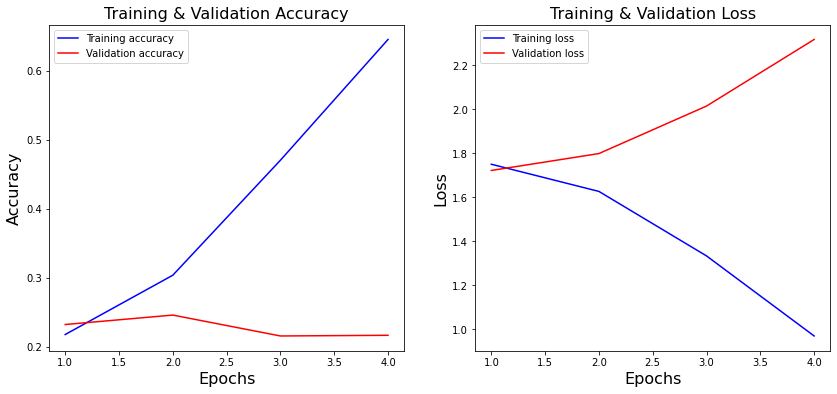

In [15]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
 
epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
#
# Plot the model accuracy vs Epochs
#
ax[0].plot(epochs, accuracy, 'b', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'red', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()
#
# Plot the loss vs Epochs
#
ax[1].plot(epochs, loss_values, 'b', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'red', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()

# Evaluación

In [20]:
loss, accuracy = model.evaluate(encoded_test, y_test_cat, batch_size=batch_size)

y_pred = np.argmax(model.predict(encoded_test), axis=1)
print('Accuracy:', accuracy_score(y_test, y_pred))

print(classification_report(y_test, y_pred, target_names=['0', '1','2','3','4','5']))

64/64 [==============================] - 11s 169ms/step
Accuracy: 0.22265625
              precision    recall  f1-score   support

           0       0.20      0.30      0.24       330
           1       0.24      0.22      0.23       399
           2       0.23      0.21      0.22       423
           3       0.24      0.23      0.24       393
           4       0.27      0.19      0.22       168
           5       0.19      0.17      0.18       335

    accuracy                           0.22      2048
   macro avg       0.23      0.22      0.22      2048
weighted avg       0.23      0.22      0.22      2048



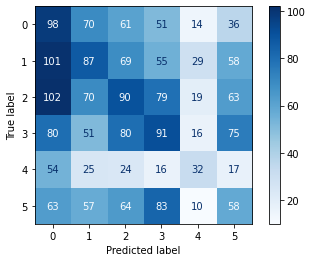

In [21]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0', '1','2','3','4','5'])
disp.plot(cmap=plt.cm.Blues,values_format='g')